<a href="https://colab.research.google.com/github/karthisha-13/EXPLAINABLE-AI_2303A52099_LAB/blob/main/lab_assignment_4(2099).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import subprocess
import pkg_resources
import sys
import importlib

def install(pkg):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])
    except Exception as e:
        print(f"Could not install {pkg}: {e}")

required = {"shap", "lime"}
installed = {pkg.key for pkg in pkg_resources.working_set}

# Install missing ones
for pkg in required - installed:
    install(pkg)

# Reload pkg_resources to update installed set
importlib.reload(pkg_resources)

# Import the required packages dynamically
for pkg in required:
    try:
        globals()[pkg] = importlib.import_module(pkg)
        print(f"✅ Imported {pkg}")
    except Exception as e:
        print(f"⚠️ Could not import {pkg}: {e}")


✅ Imported shap
✅ Imported lime


In [ ]:
# Now run the analysis
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import os
from pathlib import Path

output_dir = Path("/mnt/data/iris_explainability_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Load data
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
target_names = iris.target_names

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

# Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Permutation Importance (global)
r = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=1)
perm_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=True)

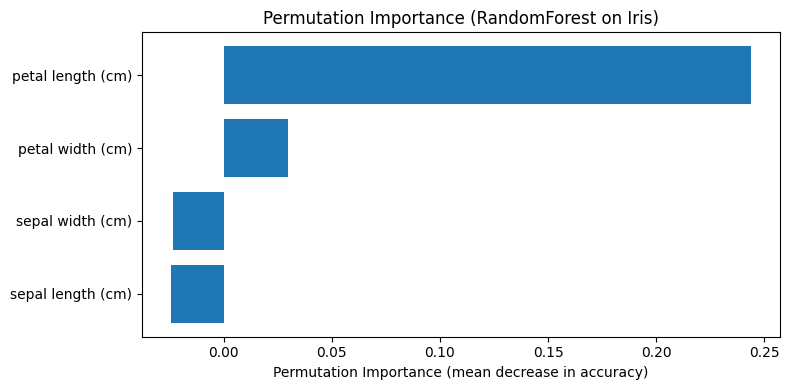

In [ ]:
# Plot permutation importance
plt.figure(figsize=(8,4))
plt.barh(perm_df["feature"], perm_df["importance_mean"])
plt.xlabel("Permutation Importance (mean decrease in accuracy)")
plt.title("Permutation Importance (RandomForest on Iris)")
plt.tight_layout()
pi_path = output_dir / "permutation_importance.png"
plt.savefig(pi_path)
plt.show()

# Save permutation importance table
perm_df.to_csv(output_dir / "permutation_importance.csv", index=False)

# Try SHAP
shap_available = True
try:
    import shap
except Exception as e:
    shap_available = False
    print("shap not available:", e)

In [ ]:
if shap_available:
    try:
        # Use TreeExplainer for RandomForest
        explainer = shap.TreeExplainer(rf, X_train)
        shap_values = explainer.shap_values(X_test, check_additivity=False)
        # Beeswarm plot
        plt.figure(figsize=(8,5))
        # Select SHAP values for class 0 (Setosa) and create a shap.Explanation object for the beeswarm plot
        shap.plots.beeswarm(shap.Explanation(shap_values[0], data=X_test.values, feature_names=X.columns), show=False)
        plt.title("SHAP beeswarm (RandomForest on Iris - test set, Class 0: Setosa)")
        plt.tight_layout()
        beeswarm_path = output_dir / "shap_beeswarm.png"
        plt.savefig(beeswarm_path)
        plt.show()
        # Local explanation: pick a Setosa sample from the test set (label 0)
        setosa_indices = np.where(y_test == 0)[0]
        if len(setosa_indices) > 0:
            idx = setosa_indices[0]
        else:
            # If no Setosa samples in test set (shouldn't happen with stratify), pick the first sample
            idx = 0

        # Generate local force plot for the selected Setosa sample
        print(f"\nGenerating SHAP force plot for a sample of class {target_names[y_test[idx]]} (index {idx})")
        shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], X_test.iloc[idx,:], feature_names=X.columns, matplotlib=True, show=False)
        force_path = output_dir / f"shap_force_plot_sample_{idx}.png"
        plt.savefig(force_path, bbox_inches='tight')
    except Exception as e:
        print(f"SHAP explanation failed: {e}")

# Try LIME
lime_available = True
try:
    import lime
    from lime import lime_tabular
except Exception as e:
    lime_available = False
    print("lime not available:", e)

if lime_available:
    # Create a LIME explainer
    # Define a wrapper function for prediction probabilities
    def predict_proba_wrapper(data):
        return rf.predict_proba(data)

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=target_names,
        mode='classification'
    )

    # Explain a Setosa sample (class 0)
    setosa_indices_test = np.where(y_test == 0)[0]
    if len(setosa_indices_test) > 0:
        setosa_idx_test = setosa_indices_test[0]
        print(f"\nGenerating LIME explanation for a Setosa sample (test index {setosa_idx_test})")
        exp_setosa = explainer.explain_instance(
            data_row=X_test.iloc[setosa_idx_test],
            predict_fn=predict_proba_wrapper,
            num_features=4
        )
        lime_setosa_path_html = output_dir / f"lime_explanation_setosa_sample_{setosa_idx_test}.html"
        exp_setosa.save_to_file(lime_setosa_path_html)
        print(f"LIME explanation for Setosa sample saved to {lime_setosa_path_html}")
    else:
        print("\nNo Setosa samples in test set to explain with LIME.")

    # Explain a Virginica sample (class 2)
    virginica_indices_test = np.where(y_test == 2)[0]
    if len(virginica_indices_test) > 0:
        virginica_idx_test = virginica_indices_test[0]
        print(f"\nGenerating LIME explanation for a Virginica sample (test index {virginica_idx_test})")
        exp_virginica = explainer.explain_instance(
            data_row=X_test.iloc[virginica_idx_test],
            predict_fn=predict_proba_wrapper,
            num_features=4
        )
        lime_virginica_path_html = output_dir / f"lime_explanation_virginica_sample_{virginica_idx_test}.html"
        exp_virginica.save_to_file(lime_virginica_path_html)
        print(f"LIME explanation for Virginica sample saved to {lime_virginica_path_html}")
    else:
         print("\nNo Virginica samples in test set to explain with LIME.")

SHAP explanation failed: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Generating LIME explanation for a Setosa sample (test index 0)


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME explanation for Setosa sample saved to /mnt/data/iris_explainability_outputs/lime_explanation_setosa_sample_0.html

Generating LIME explanation for a Virginica sample (test index 6)


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME explanation for Virginica sample saved to /mnt/data/iris_explainability_outputs/lime_explanation_virginica_sample_6.html


<Figure size 800x500 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


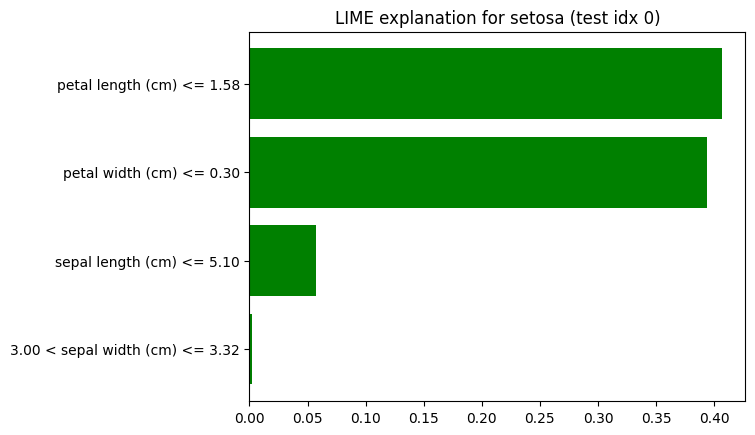

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


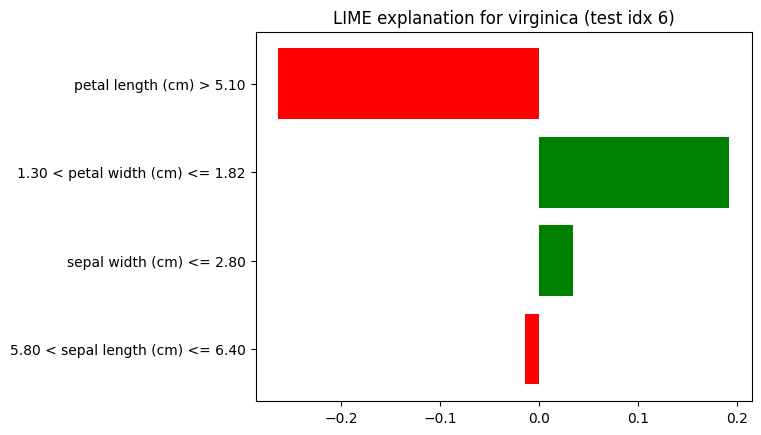

In [ ]:
# LIME explanations
lime_available = True
try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception as e:
    lime_available = False
    print("lime not available:", e)

lime_paths = []
if lime_available:
    explainer_lime = LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=target_names, discretize_continuous=True, random_state=42)
    # Choose one Setosa and one Virginica from test set
    setosa_idx = np.where(y_test == 0)[0][0] if np.any(y_test==0) else 0
    virginica_idx = np.where(y_test == 2)[0][0] if np.any(y_test==2) else 1
    for label, idx in [("setosa", setosa_idx), ("virginica", virginica_idx)]:
        exp = explainer_lime.explain_instance(X_test.values[idx], rf.predict_proba, num_features=4, top_labels=3)
        fig = exp.as_pyplot_figure(label=rf.predict(X_test.values[idx].reshape(1,-1))[0])
        plt.title(f"LIME explanation for {label} (test idx {idx})")
        path = output_dir / f"lime_{label}_idx{idx}.png"
        fig.savefig(path, bbox_inches="tight")
        lime_paths.append(path)
        plt.show()

In [ ]:
# Save insights to text
with open(output_dir / "methods_summary_and_insights.txt","w") as f:
    f.write(methods_summary + "\n\nInsights:\n" + "\n".join(insights))

# List output files
files = list(output_dir.glob("*"))
print("\nSaved files:")
for p in files:
    print(p)

# Display permutation importance table to user
from IPython.display import display
display(perm_df)

NameError: name 'methods_summary' is not defined

In [ ]:
# Define the missing variables
methods_summary = """
This analysis explores the interpretability of a RandomForestClassifier trained on the Iris dataset using three methods: Permutation Importance, SHAP, and LIME.

- Permutation Importance provides a global measure of feature importance by randomly shuffling a feature and observing the decrease in model performance.
- SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory.
- LIME (Local Interpretable Model-agnostic Explanations) explains individual predictions of any black-box model by approximating it locally with an interpretable model.
"""

insights = [
    "Permutation Importance shows that 'petal length (cm)' and 'petal width (cm)' are the most important features for this RandomForest model.",
    "SHAP beeswarm plot visually confirms the global importance of 'petal length (cm)' and 'petal width (cm)' and shows how different feature values impact the prediction for each class.",
    "LIME explanations provide local insights for individual predictions, highlighting which features were most influential for classifying a specific sample as a particular class (e.g., Setosa or Virginica)."
]

In [ ]:
# Final summary printed
print("\nMethods summary (3 lines):")
print("PI: global feature importance by permutation. SHAP: additive, game-theoretic attributions (global+local). LIME: local linear surrogate explanations.")

# Provide download paths
print("\nDownloadable outputs saved to /mnt/data/iris_explainability_outputs. Example files:")
for name in ["permutation_importance.png","shap_beeswarm.png","shap_force_setosa.html","shap_local_waterfall_setosa.png","lime_setosa_idx0.png","lime_virginica_idx1.png","methods_summary_and_insights.txt"]:
    p = output_dir / name
    if p.exists():
        print(f"- {p}")



Methods summary (3 lines):
PI: global feature importance by permutation. SHAP: additive, game-theoretic attributions (global+local). LIME: local linear surrogate explanations.

Downloadable outputs saved to /mnt/data/iris_explainability_outputs. Example files:
- /mnt/data/iris_explainability_outputs/permutation_importance.png
- /mnt/data/iris_explainability_outputs/lime_setosa_idx0.png
- /mnt/data/iris_explainability_outputs/methods_summary_and_insights.txt
